In [2]:
import numpy as np
import pandas as pd
from utils import misc
from utils.misc import get_attr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

from gym_env import TradingEnv

pd.set_option('mode.chained_assignment', None)

In [3]:
spy_df = pd.read_csv('datasets/price_series/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


In [4]:
def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df.copy()
df['signal'] = df['adjclose'].rolling(10).mean() - df['adjclose'].rolling(20).mean()
df['signal+1'] = df['signal'].shift(1)
df['returns'] = np.insert(df['close'].to_numpy()[1:] / df['close'].to_numpy()[:-1], 1, 0) - 1
df['volatility'] = df['returns'].rolling(30).std()

df = df.dropna()
df


# print(env.records['portfolio_volatility'])

,date,open,high,low,close,adjclose,volume,ticker,signal,signal+1,returns,volatility
29,1993-03-12,45.187500,45.218750,44.812500,45.093750,25.881849,643600,SPY,0.366797,0.331822,-0.010288,0.182937
30,1993-03-15,45.062500,45.312500,45.062500,45.312500,26.007406,310800,SPY,0.405359,0.366797,0.004851,0.182920
31,1993-03-16,45.312500,45.437500,45.312500,45.312500,26.007406,30800,SPY,0.373969,0.405359,0.000000,0.008342
32,1993-03-17,45.250000,45.250000,44.968750,45.031250,25.845985,21800,SPY,0.322851,0.373969,-0.006207,0.008435
33,1993-03-18,45.218750,45.500000,45.218750,45.312500,26.007406,59300,SPY,0.293255,0.322851,0.006246,0.008294
...,...,...,...,...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY,-4.404001,-4.448500,-0.018450,0.010437
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY,-4.392001,-4.404001,-0.014429,0.010488
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY,-4.495003,-4.392001,-0.001425,0.010463
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY,-3.893004,-4.495003,0.016530,0.010763


In [5]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'dones'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Save a transition
        '''
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


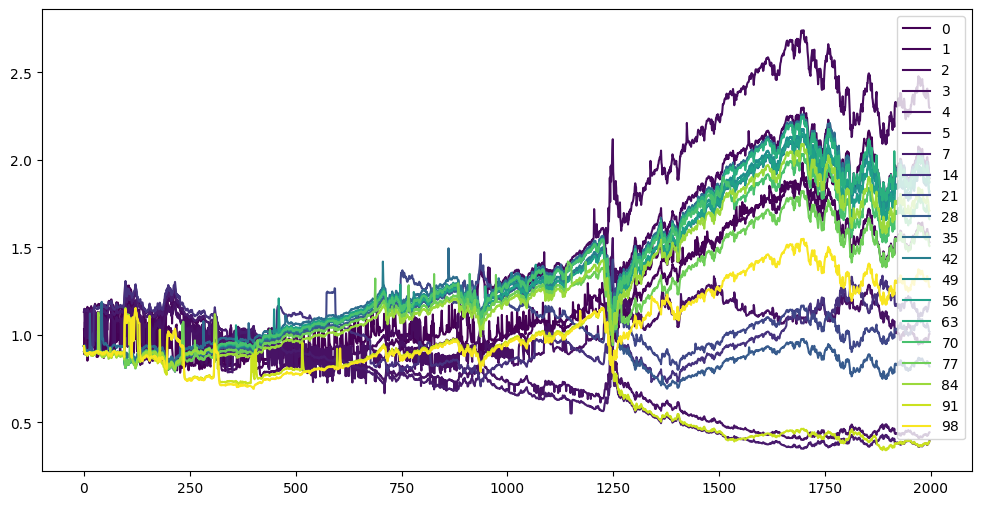

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # Initialize the DQN
        self.dqn = DQN(state_size, action_size)
        # Define the target network
        self.target_dqn = DQN(state_size, action_size)

        # Copy the weights from the DQN network to the target network
        self.update_target_network()

        self.memory = ReplayMemory(100000)
        
        # Define the device to use for training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dqn.to(self.device)
        
        # Define the exploration parameters
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
    def select_action(self, state):
        with torch.no_grad():
            # Convert the state to a PyTorch tensor
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

            # Compute the Q-values for the state
            q_values = self.dqn(state)
            
            # Split the Q-values into two halves
            half_size = int(self.action_size / 2)
            q1, q2 = q_values.split(half_size, dim=1)
            # print(q1)
            # print(q2)

            # Compute the index of the action with the highest Q-value for each half
            action1 = q1.argmax().item()
            action2 = q2.argmax().item()

            


        # Decay the exploration parameter
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Choose a random action with probability epsilon
        if np.random.rand() < self.epsilon:
            action1 = np.random.randint(half_size)
            action2 = np.random.randint(half_size)
        
        return action1, action2
    
    def learn(self, optimizer, batch_size, gamma=0.99):
        # Sample a batch of experiences from the replay memory
        experiences = self.memory.sample(batch_size)

        batch = Transition(*zip(*experiences))
        states = torch.tensor(np.array(batch.state), dtype=torch.float32)
        actions = torch.tensor(np.array(batch.action), dtype=torch.int64)
        next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32)
        rewards = torch.tensor(np.array(batch.reward), dtype=torch.float32)
        dones = torch.tensor(np.array(batch.dones), dtype=torch.float32)
        

        # Compute the Q-values for the current state-action pairs using the DQN network
        current_q_values = self.dqn(states).gather(1, actions).squeeze(1)
        
        A = self.target_dqn(next_states)
        # Reshape A to have shape (128, 2, 9)
        A_reshaped = A.view(batch_size, 2, 9)

        # Take the maximum value along the last dimension (which has size 9)
        B, _ = A_reshaped.max(dim=-1)
        
        # Compute the Q-values for the next states using the target network
        next_q_values = B
        rewards = rewards.unsqueeze(1)
        rewards = torch.cat((rewards, rewards), dim=1)
        # Compute the expected Q-values using the Bellman equation
        expected_q_values = rewards + gamma * next_q_values
        

        # Compute the loss between the current Q-values and the expected Q-values
        loss = F.smooth_l1_loss(current_q_values, expected_q_values)
        
        # Update the DQN network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def update_target_network(self):
        # Copy the weights from the DQN network to the target network
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        
input_feature_list = [
    'open',
    'high',
    'low',
    'close',
    'adjclose',
    'signal',
    'signal+1',
    'volume',
    'volatility'
]

df = df[-2000:]
env = TradingEnv(df=df, input_feature_list=input_feature_list)

import torch.optim as optim




agent = DQNAgent(len(input_feature_list) + 4, 18)

# Set up the optimizer
optimizer = optim.Adam(agent.dqn.parameters(), lr=0.001)

# Run the environment for one episode
state = env.reset()
done = False


plt.figure(figsize=(12, 6))
episode = 0
batch_size = 1000
action_list = []
num_episodes = 100
colors = plt.cm.viridis(np.linspace(0, 1, num_episodes))
for episode in tqdm(range(num_episodes)):
    total_reward = 0
    while not done:

        # Select an action using the DQN agent
        action1, action2 = agent.select_action(state)

        
        
        action_list.append((action1, action2))

        # Take the action in the environment
        next_state, reward, done, info = env.step([action1, action2])
        # if reward == 0: print(next_state, reward, done, info)

        # Add the experience to the replay memory
        agent.memory.push(state, [action1, action2], next_state, reward, done)

        # Move to the next state
        state = next_state
        total_reward += reward

        # Update the DQN agent
        if len(agent.memory) > batch_size:
            agent.learn(optimizer, batch_size)
    
    # Print the total reward for the episode
    # print("Episode {}: Total reward = {}".format(episode, total_reward))

        # Update the target network every 10 episodes
    
    if episode % 6 == 0:
        agent.update_target_network()
    if episode <= 5 or episode % 7 == 0:
        plt.plot(env.records['portfolio_return'], label=episode, color=colors[episode])
    state = env.reset()
    done = False


plt.legend()
plt.show()
